# Rotten Tomatoes Reviews
by Stuart Miller  
[Github](https://github.com/sjmiller8182)

**Objective:** Predict 'freshness' of critic review  

[Rotten Tomatoes](https://www.rottentomatoes.com/) rates movies as ['fresh' or 'rotten'](https://www.rottentomatoes.com/about#whatisthetomatometer). A movie is rated a 'fresh' when at least 60% of the critic reviews are positive and rotten when less than 60% of the critic reviews are positive. In some cases, the critics give the movie a numerical or graded rating such as '3/4' or 'A+'. However, in many cases, the critic does not give a rating or grade and the 'freshness' of the review must be inferred from the review. This will be the objective of this project: predicting the freshness of critic reviews.  

Data was previously scraped with [TomatoPy](https://github.com/sjmiller8182/tomatopy). See Data Collection notebook for details.

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
%matplotlib inline

Load data from file. Open and ignore encoding errors.

In [31]:
data_trans = [[],[],[],[],[],[],[],[]]
with codecs.open('reviews.tsv', "r",encoding='utf-8', errors='ignore')  as fdata:
    for line in fdata:
        data = line.strip().split('\t')
        for i in range(len(data)):
            data_trans[i].append(data[i])

Load data into DataFrame for analysis.

In [32]:
data = pd.DataFrame()
keys = ['id', 'reviews', 'rating', 'fresh', 'critic',
        'top_critic', 'publisher', 'date']

for i in range(len(data_trans)):
    data[keys[i]] = data_trans[i]

## Data Frame Structure
The table contained 7 columns of data and a column of foreign keys. Keys match review data to movie info, which was also scraped.
- id: table foreign key
- reviews: text of critic reviews
- rating: rating
- fresh: freshness of review - fresh or rotten
- critic: critic name
- top_critic: if critic is considered a 'top critic' 1 or 0
- publisher: publisher or review
- date: date of review

Of the 54,432 rows, there are 48,869 reviews and 40,915 ratings. There are 35,379 rows where rating and review is not null. There are no null fresh rows.

In [33]:
data.head()

,id,reviews,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,"""Continuing along a line introduced in last ye...",,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,,fresh,,0,Cinema Scope,"October 12, 2017"


In [35]:
data.replace(to_replace = '', value = pd.np.nan, inplace = True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
id            54432 non-null object
reviews       48869 non-null object
rating        40915 non-null object
fresh         54432 non-null object
critic        51710 non-null object
top_critic    54432 non-null object
publisher     54123 non-null object
date          54432 non-null object
dtypes: object(8)
memory usage: 3.3+ MB


In [40]:
data[(data.reviews.notnull() & data.rating.notnull())].shape

(35379, 8)

## Assessment and Exploration

### Reviews
The reviews will need some preprocessing before using in classification models. The initial preprocessing will be done here. This is just a matter of converting all the words to lower case and removing all the punctuation.

In [274]:
def preprocess_rev(row):
    if 'str' in str(type(row['reviews'])):
        # some common symbols
        punc = ['~','!','`',',',':',';','"',"'",'.','/',
                '\\','[',']','(',')','&','%','-','_','+','=','?']
        rev = row['reviews'].lower().strip()
        for p in punc:
            rev = rev.replace(p,'')
        return rev
    else:
        return np.nan

data['review_pp'] = data.apply(preprocess_rev, axis = 1)

In [275]:
print('Sample original review:')
print(list(data['reviews'])[10])

print('\nSample modified review:')
print(list(data['review_pp'])[10])

Sample original review:
"Cosmopolis"" is a hypnotic examination of our modern anxieties about the dehumanization brought on by wealth, power, and technology."

Sample modified review:
cosmopolis is a hypnotic examination of our modern anxieties about the dehumanization brought on by wealth power and technology


### Ratings
Ratings can be given as a number or as a grade. Since this is a classification task, the numerical values should be mapped to grades. Then the grades can be one-hot encoded is common for classification labeling.

In addition to the mapping, some of these values need to be corrected. For instance, some of the catpured ratings are non-grade letters like 'N' and some are numerical values but do not indicate scale.

In [85]:
np.unique(list(data[data.rating.notnull()].rating))

array(['0', '0.5/10', '0.5/4', '0.5/5', '0/10', '0/4', '0/5', '0/6', '1',
       '1-5', '1.0', '1.0/4', '1.0/5', '1.5', '1.5/10', '1.5/4', '1.5/5',
       '1.6/5', '1.7', '1.8', '1.9/5', '1/10', '1/2', '1/4', '1/5', '1/6',
       '2', '2.0/4', '2.0/5', '2.1/2', '2.2', '2.2/5', '2.3/10', '2.3/4',
       '2.3/5', '2.4/5', '2.5', '2.5/10', '2.5/4', '2.5/5', '2.6/5',
       '2.6/6', '2.7', '2.7/5', '2/10', '2/2', '2/4', '2/5', '2/6', '3',
       '3 1/2', '3.0', '3.0/10', '3.0/4', '3.0/5', '3.1', '3.1/5', '3.2',
       '3.3', '3.3/5', '3.4', '3.5', '3.5/10', '3.5/4', '3.5/5', '3.6/5',
       '3.7', '3.7/5', '3.8/10', '3.8/5', '3/10', '3/2', '3/4', '3/5',
       '3/6', '4', '4.0', '4.0/10', '4.0/4', '4.0/5', '4.1', '4.1/10',
       '4.2', '4.2/10', '4.2/5', '4.3/10', '4.3/5', '4.4/5', '4.5',
       '4.5/10', '4.5/5', '4.7', '4.8', '4.9', '4.9/10', '4/10', '4/4',
       '4/5', '4/6', '5', '5.0/10', '5.0/5', '5.2', '5.5/10', '5.5/5',
       '5.8', '5.8/10', '5.9', '5.9/10', '5/10', '5/4', '5/5

In [161]:
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
       'D+', 'D', 'D-', 'F+', 'F', 'F-']
rotten_count = list()
fresh_count = list()

for grade in grades:
    total = (data[data['rating'] == grade]['fresh'] == 'fresh').count()
    fresh = (data[data['rating'] == grade]['fresh'] == 'fresh').sum()
    rotten = total-fresh
    
    rotten_count.append(rotten)
    fresh_count.append(fresh)

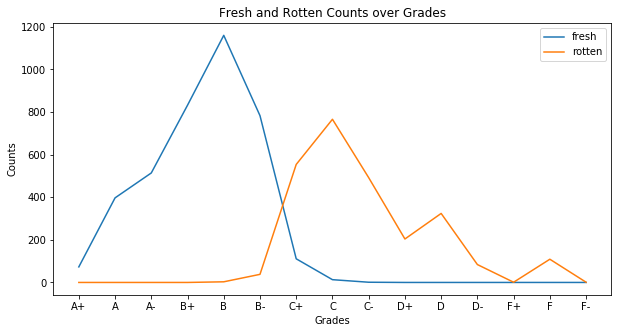

In [180]:
x = [_ for _ in range(len(grades))]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,fresh_count, label = 'fresh');
ax.plot(x,rotten_count, label = 'rotten');
ax.set_title("Fresh and Rotten Counts over Grades");
ax.set_ylabel('Counts')
ax.set_xlabel('Grades')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend();

### Ratings Mapping
Based on the graph of fresh and rotten counts over the grades given by critics, the cross over point appears to be between B- and C-. I will map B- to 0.6, which is the minimum positive rating. The other numerical ratings will be mapped to grades as shown below.

| Grade | Numerical | Grade | Numerical | Grade | Numerical | Grade | Numerical | Grade | Numerical |
|-------|-----------|-------|-----------|-------|-----------|-------|-----------|-------|-----------|
| A+    | 1         | B+    | 0.76      | C+    | 0.52      | D+    | 0.28      | F+    | 0.04      |
| A     | 0.92      | B     | 0.68      | C     | 0.44      | D     | 0.2       | F     | 0         |
| A-    | 0.84      | B-    | 0.6       | C-    | 0.36      | D-    | 0.12      | F-    | 0         |

In [221]:
def map_numbers_to_grades(num):
    if num == np.nan:
        return np.nan
    else:
        if num == 1:
            return 'A+'
        elif num < 1 and num >= 0.92:
            return 'A'
        elif num < 0.92 and num >= 0.84:
            return 'A-'
        elif num < 0.84 and num >= 0.76:
            return 'B+'
        elif num < 0.76 and num >= 0.68:
            return 'B'
        elif num < 0.68 and num >= 0.6:
            return 'B-'
        elif num < 0.6 and num >= 0.52:
            return 'C+'
        elif num < 0.52 and num >= 0.44:
            return 'C'
        elif num < 0.44 and num >= 0.36:
            return 'C-'
        elif num < 0.36 and num >= 0.28:
            return 'D+'
        elif num < 0.28 and num >= 0.2:
            return 'D'
        elif num < 0.2 and num >= 0.12:
            return 'D-'
        elif num < 0.12 and num >= 0.04:
            return 'F+'
        else:
            return 'F'

def clean_ratings(row):
    if row['rating'] in grades:
        return row['rating']
    else:
        if row['rating'] in ['T','R','N']:
            return np.nan
        elif '-' in str(row['rating']):
            a = row['rating'].split('-')[0]
            b = row['rating'].split('-')[1]
            return map_numbers_to_grades(float(a)/float(b))
        elif ' ' in str(row['rating']):
            a = row['rating'].split(' ')[0]
            b = row['rating'].split(' ')[1]
            if '/' in b:
                b = float(b.split('/')[0])/float(b.split('/')[0])
            a = (float(a) + b)/5
            return map_numbers_to_grades(a)
        elif '/' in str(row['rating']):
            a = row['rating'].split('/')[0]
            b = row['rating'].split('/')[1]
            return map_numbers_to_grades(float(a)/float(b))
        elif float(row['rating']) > 5:
            return map_numbers_to_grades(float(row['rating'])/10.0)
        elif float(row['rating']) < 5 and float(row['rating']) < 1:
            if row['fresh'] == 'fresh':
                return map_numbers_to_grades(float(row['rating'])/(float(row['rating'])+1))
            else:
                return map_numbers_to_grades(float(row['rating'])/(float(row['rating'])+3))
        else:
            return np.nan

In [222]:
data['grade'] = data.apply(clean_ratings, axis = 1)

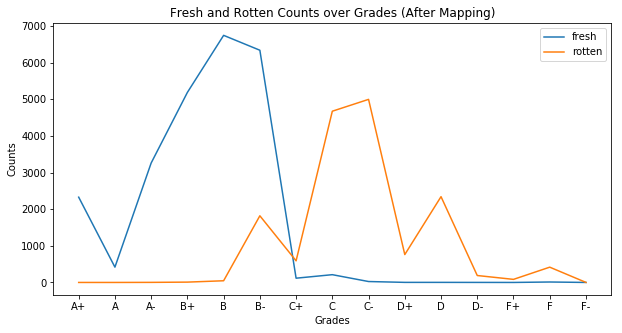

In [404]:
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
       'D+', 'D', 'D-', 'F+', 'F', 'F-']
rotten_count = list()
fresh_count = list()

for grade in grades:
    total = (data[data['grade'] == grade]['fresh'] == 'fresh').count()
    fresh = (data[data['grade'] == grade]['fresh'] == 'fresh').sum()
    rotten = total-fresh
    
    rotten_count.append(rotten)
    fresh_count.append(fresh)
    
x = [_ for _ in range(len(grades))]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,fresh_count, label = 'fresh');
ax.plot(x,rotten_count, label = 'rotten');
ax.set_title("Fresh and Rotten Counts over Grades (After Mapping)");
ax.set_ylabel('Counts')
ax.set_xlabel('Grades')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend();

After mapping the ratings to grades, it looks like there is some noise near the cross over point. I will leave it like this. Some noise near the cross over area is to be expected. It is possilbe that Rotten Tomatoes has misclassified some of these ratings.

For modeling, it could be possible to treat the B- and C ratings as neutral and train on the more consistent grades.

### Target Class Reduction
Since the model is really trying to learn the difference between positive and negative reviews (fresh and rotten), it makes sense to compress the graded representation to 2 classes. Becuase of the noise in the B-, C+ range, I will ignore these and consider them neutral reviews.

In [459]:
def compress_classes(row):
    if row['grade'] in ['A+', 'A', 'A-', 'B+', 'B']:
        return 'pos'
    elif row['grade'] in ['C', 'C-','D+', 'D', 'D-', 'F+', 'F', 'F-']:
        return 'neg'
    else:
        return row['grade']
    
data['pos_neg'] = data.apply(compress_classes, axis = 1)

### General Exploration
Common words
- What are the most common words in the total set?
- Is there a difference between the most common words in the positive set and negative set?

In [622]:
from collections import Counter

words = Counter()
rev_lengths = list()
for rev in list(data.review_pp):
    if 'float' not in str(type(rev)):
        n_rev = rev.split(' ')
        rev_lengths.append(len(n_rev))
        words.update(n_rev)
total = len(list(words.elements()))
print('There are {} unique words in the total set.'.format(total))

There are 981985 unique words in the total set.


In [623]:
words.most_common(120)[100:]

[('her', 995),
 ('first', 994),
 ('action', 978),
 ('really', 975),
 ('drama', 966),
 ('performances', 965),
 ('made', 960),
 ('get', 956),
 ('would', 953),
 ('something', 951),
 ('isnt', 942),
 ('do', 934),
 ('better', 924),
 ('full', 922),
 ('should', 902),
 ('see', 900),
 ('many', 888),
 ('two', 880),
 ('through', 879),
 ('them', 870)]

Most of the words in the set are not interesting unit about the 100th most common where words like performances and drama start showing up.

In [620]:
revs = dict()
revs['f'] = list(data[data['fresh']=='fresh'].review_pp)
revs['r'] = list(data[data['fresh']=='rotten'].review_pp)

words = {'f':Counter(), 'r':Counter()}
rev_lens = {'f':list(), 'r':list()}
for fresh in ['f', 'r']:
    for rev in revs[fresh]:
        if 'float' not in str(type(rev)):
            n_rev = rev.split(' ')
            rev_lens[fresh].append(len(n_rev))
            words[fresh].update(n_rev)

In [ ]:
# check top words

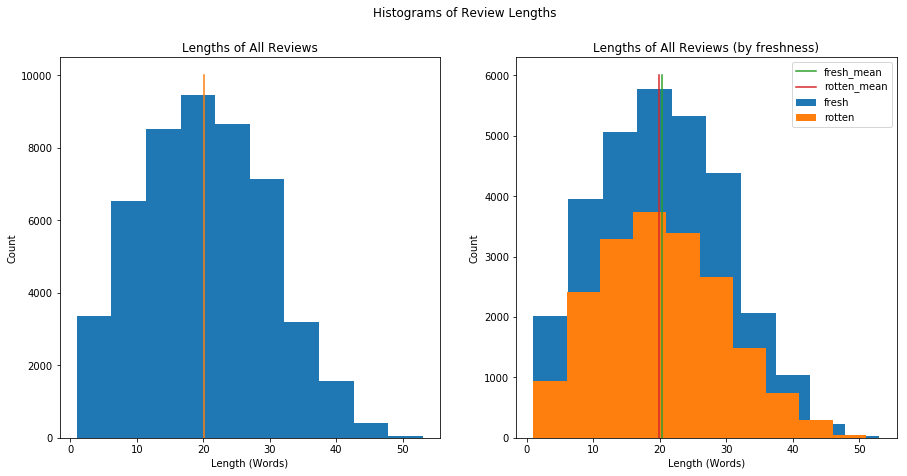

In [635]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,7))
avg_all = np.mean(rev_lengths)
avg_r = np.mean(rev_lens['r'])
avg_f = np.mean(rev_lens['f'])
ax[0].hist(rev_lengths);
ax[0].plot([avg_all, avg_all], [0,10000])
ax[0].set_title('Lengths of All Reviews');
ax[0].set_xlabel('Length (Words)');
ax[0].set_ylabel('Count');
ax[1].hist(rev_lens['f'], label = 'fresh');
ax[1].hist(rev_lens['r'], label = 'rotten');
ax[1].plot([avg_f, avg_f],[0,6000], label = 'fresh_mean')
ax[1].plot([avg_r, avg_r],[0,6000], label = 'rotten_mean')
ax[1].set_title('Lengths of All Reviews (by freshness)');
ax[1].set_xlabel('Length (Words)');
ax[1].set_ylabel('Count');
ax[1].legend();
fig.suptitle('Histograms of Review Lengths');

Based on the histograms above, fresh and rotten reviews appear to have the similar length characteristics.

## Modeling
I am planning on using three models:
- Naive Bayes
- Linear Model
- SVM

why these models?

**Review Labeling:** There are two way to label the reviews with this dataset. 
1. Label the reviews based on the fresh column.
2. Label the reivews based on the critic rating.

I plan on doing the second option. This would be the normal application of this kind of modeling. A model would be trained on reviews where the critic gave a text review and a numerical or graded rating. Then the model would be used to classify ratings where the critics did not provide numerical or grading ratings.

### Data Preparation
- Extract features with CountVectorizer from `sklearn`.
- Split rows into training and testing; 33% of data for testing.

In [463]:
m_data = data[['review_pp','grade','fresh','pos_neg']].dropna()
m_data = m_data[(m_data['pos_neg'] == 'neg') | (m_data['pos_neg'] == 'pos')]

In [484]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(m_data['review_pp'], 
                                                    m_data['pos_neg'], 
                                                    random_state=49,
                                                    test_size = 0.33,
                                                    shuffle = True)
# vectorize reviews
count_vec = CountVectorizer()
training_data = count_vec.fit_transform(X_train)
testing_data = count_vec.transform(X_test)

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(training_data)
X_test_tfidf = tfidf_transformer.fit_transform(testing_data)

### Model Training Pipeline


In [567]:
# import models
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# some containers
models = dict()
predictions = dict()
t = dict()
rand_state = 49

# make models
models['naive_bayes'] = MultinomialNB(alpha = 1)
models['sgd'] = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=rand_state, max_iter=7, tol=None)
models['svm'] = SVC(random_state=rand_state)

# train and run models
for model in models.keys():
    t0 = time.time()
    models[model].fit(training_data, y_train)
    t1 = time.time()
    predictions[model] = models[model].predict(testing_data)
    t2 = time.time()
    t[model] = {'train': t1-t0, 'test': t2-t1}
    print('Trained and tested ' + model)

Trained and tested naive_bayes
Trained and tested sgd
Trained and tested svm


In [568]:
# import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# calc metrics
for m in models.keys():
    pred = predictions[m]
    print('\n' + m.title() + ' performance')
    print('Accuracy score: {:.4f}'. format(accuracy_score(y_test, pred)))
    print('Precision score: {:.4f}'. format(precision_score(y_test, pred, average = 'weighted')))
    print('Recall score: {:.4f}'. format(recall_score(y_test, pred, average = 'weighted')))
    print('Training Time: {:.2f} s; Testing time: {:.2f} s'.format(t[m]['train'], t[m]['test']))


Naive_Bayes performance
Accuracy score: 0.8094
Precision score: 0.8089
Recall score: 0.8094
Training Time: 0.04 s; Testing time: 0.00 s

Sgd performance
Accuracy score: 0.7741
Precision score: 0.7756
Recall score: 0.7741
Training Time: 0.02 s; Testing time: 0.00 s

Svm performance
Accuracy score: 0.5794
Precision score: 0.3357
Recall score: 0.5794
Training Time: 54.28 s; Testing time: 19.94 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Clustering Experiment

In [554]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=5, random_state = rand_state)
clustering.fit(training_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=49, tol=0.0001, verbose=0)

In [557]:
clustering.predict(testing_data[10])

array([1])

In [559]:
from collections import Counter
Counter(clustering.labels_)

Counter({3: 7638, 4: 3594, 0: 3612, 1: 1801, 2: 1943})

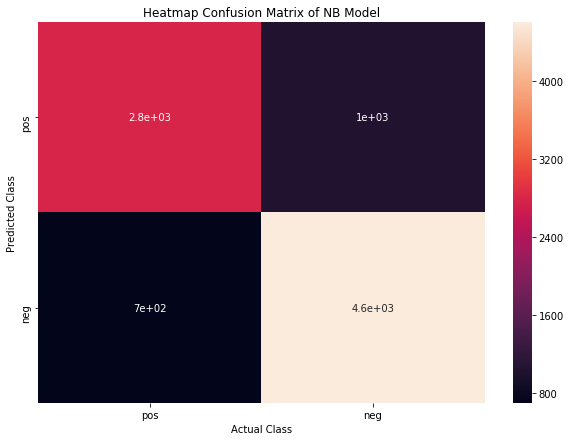

In [520]:
array = confusion_matrix(y_test, predictions['naive_bayes'])
df_cm = pd.DataFrame(array, index = [i for i in ['pos','neg']],
                  columns = [i for i in ['pos','neg']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True);
plt.ylabel('Predicted Class');
plt.xlabel('Actual Class');
plt.title('Heatmap Confusion Matrix of NB Model');

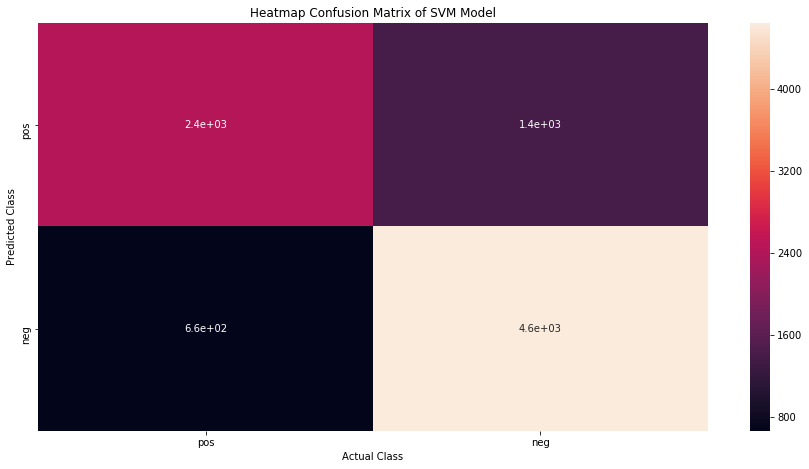

In [483]:
array = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(array, index = [i for i in ['pos','neg']],
                  columns = [i for i in ['pos','neg']])
plt.figure(figsize = (15,7.5))
sns.heatmap(df_cm, annot=True);
plt.ylabel('Predicted Class');
plt.xlabel('Actual Class');
plt.title('Heatmap Confusion Matrix of SVM Model');